In [1]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from tools.util import load_pkl, dump_pkl
from systems.pacircle import PACircle

#Example code -- only four monomers
NCELLS = 4 #Number of HCCH monomers
N_PER_FRAG = 1 #Number of HCCH / LAS fragment
DIST = 2.47 #Distance

geom = PACircle(DIST,NCELLS,N_PER_FRAG,fn="logs/pacircle.log",basis="3-21g")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_()
las.ci = sign_control.fix_sign(las) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

#MC-PDFT Integration (takes a while)
print("Computing MC-PDFT Energies...")
start = time.perf_counter()
from mrh.my_pyscf import mcpdft
mc = mcpdft.LASSI(lsi, 'tPBE', las.ncas_sub, las.nelecas_sub, states=list(range(len(energies_lassi))))
energies_lsipdft,_,_,_,_,_,_ = mc.kernel()
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

#Save to disk
#Results from paper are saved in logs/ already
las_charges = util.las_charges(las)
data = {"energies_lassi":energies_lassi,
        "energies_lassipdft":energies_lsipdft,
        "civecs":civecs_lassi,
        "charges":las_charges,
        "nfrags":geom.nfrags,
        "dist":geom.dist,
        "mf_coeff":geom.mf_coeff,
        "mf_occ":geom.mf_occ,
        "mf_ene":geom.mf_ene,
       }
d = int(DIST*10)
data_name = f"logs/pa{NCELLS}_frag{N_PER_FRAG}_dist{d}_lsipdft"
dump_pkl(data,f"{data_name}.pkl")

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


overwrite output file: logs/pacircle.log
Initiating LAS Model Space...
Done. Time elapsed: 0.3953299201093614 seconds
Running LASSI...
Done. Time elapsed: 0.046324362978339195 seconds
Computing MC-PDFT Energies...


/tmp/ipykernel_2148562/1446914933.py:40: FutureWarning: Most MC-PDFT and MC-DCFT modules have been moved to pyscf-forge (github.com/pyscf/pyscf-forge) and will be removed from mrh soon.
  from mrh.my_pyscf import mcpdft


Done. Time elapsed: 1.9650970129296184 seconds


,LASSI-tPBE0
IP,5.10
EA,1.81
GAP,3.30


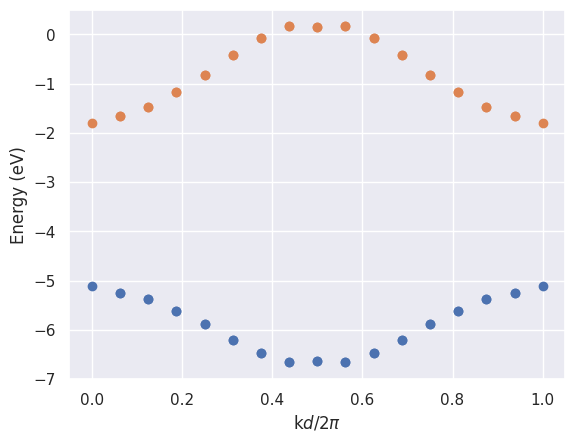

In [47]:
%load_ext autoreload
%autoreload 2

from tools import bandh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools.util import load_pkl, LASdata, PeriodicData
sns.set()

las = LASdata(pkl_fn="logs/pa64_frag4_dist24_lsipdft.pkl")
las.make_bands()